### count 값을 회귀 예측하는 모델 (자전거 수요 예측)
- 최대한 R2을 높게

In [46]:
import pandas as pd
import seaborn as sns
bike = pd.read_csv('bike data.csv')

del bike['windspeed']


bike['datetime'] = pd.to_datetime(bike['datetime'])
bike["year"] = bike['datetime'].dt.year
bike["month"] = bike['datetime'].dt.month
bike["day"] = bike['datetime'].dt.day
bike["hour"] = bike['datetime'].dt.hour
bike["weekday"] = bike['datetime'].dt.weekday

del bike['datetime']

bike.head()

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,month,day,hour,weekday
0,1,0,0,1,9.84,14.395,81,16,2011,1,1,0,5
1,1,0,0,1,9.02,13.635,80,40,2011,1,1,1,5
2,1,0,0,1,9.02,13.635,80,32,2011,1,1,2,5
3,1,0,0,1,9.84,14.395,75,13,2011,1,1,3,5
4,1,0,0,1,9.84,14.395,75,1,2011,1,1,4,5


In [36]:
# Y에 영향을 미칠 변수들 확인

##### 풍속 data 0이 많이 보임 
- 풍속이 0이 많아 -> 학습에 불필요할 것 같음
- 풍속 data 삭제

<Axes: xlabel='windspeed', ylabel='count'>

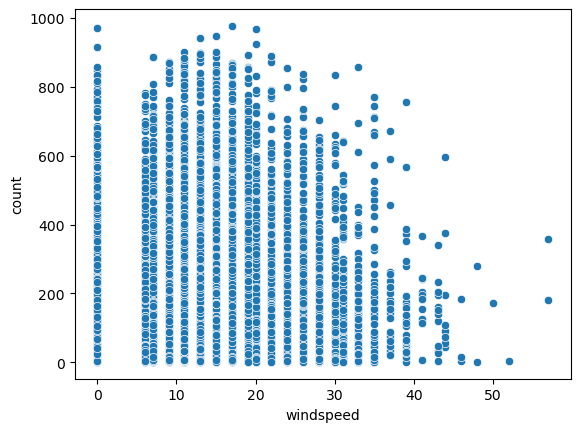

In [38]:
sns.scatterplot(data=bike, x='windspeed',y='count')

##### 시간이 수요에 영향을 미칠까 확인
- 출근 시간이랑 퇴근시간에 많이 빌리는 것 같음

<Axes: xlabel='hour', ylabel='count'>

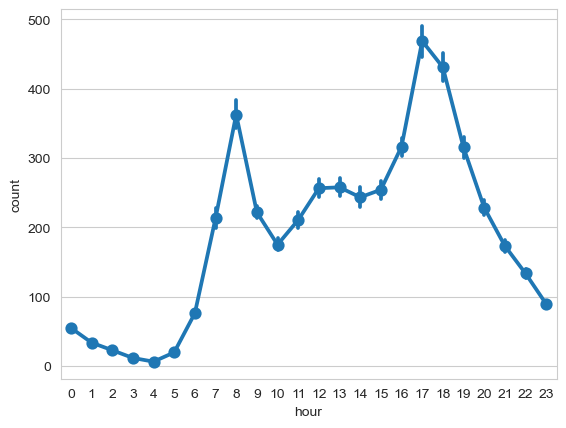

In [49]:
sns.set_style('whitegrid')
sns.pointplot(data=bike,x='hour',y='count')

<Axes: xlabel='hour', ylabel='count'>

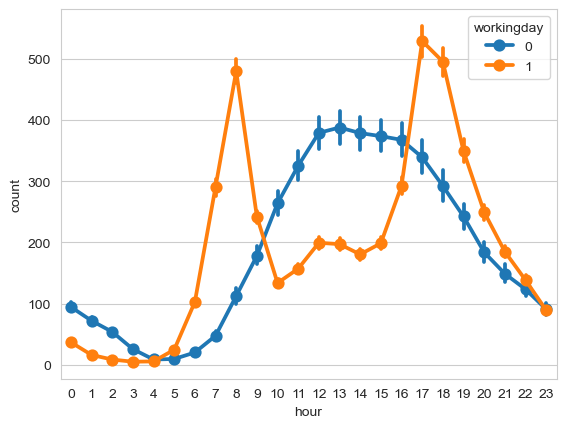

In [56]:
sns.set_style('whitegrid')
sns.pointplot(data=bike,x='hour',y='count',hue='workingday')

# 출근하는 날에는 출,퇴근 시간에 많이 빌리는 것을 알 수 있음
# 출근하지 않는 날에는 점심시간에 많이 빌리는걸 알 수 있음

##### 랜덤 포레스트(회귀) 
- R2 확인하기


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = bike.drop('count',axis =1).to_numpy()
Y = bike['count'].to_numpy()

train_x,test_x, train_y,test_y = train_test_split(X,Y) 

model = RandomForestRegressor()
model.fit(train_x,train_y)
model.score(test_x,test_y)

0.950289918911234

##### XGBoost 학습원리
- 부스팅 : 약한 학습기(찍는것보단 나은 수준)

In [71]:
from sklearn.tree import DecisionTreeRegressor

model1 = DecisionTreeRegressor(max_depth=2) # 약한 학습기
model1.fit(train_x,train_y)

pred1 = model1.predict(train_x)

error1 = train_y-pred1  # 예측이 얼마나 틀렸는지 확인
error1

array([-163.50615725, -139.50615725,  -38.2863671 , ..., -179.50615725,
         19.49384275,  -40.6       ])

In [75]:
model2 = DecisionTreeRegressor(max_depth=2)
model2.fit(train_x,error1)

pred2 = model2.predict(train_x)

error2 = error1 - pred2
error2

array([-131.89164985, -107.89164985,   63.55266157, ...,  -77.66712858,
         51.10835015,   -8.9854926 ])

In [77]:
model3 = DecisionTreeRegressor(max_depth=2)
model3.fit(train_x,error2)

pred3 = model3.predict(train_x)

error3 = error2 - pred3
error3

array([-87.37579847, -63.37579847,  64.61069206, ..., -76.60909808,
        52.16638064,  -2.89417232])

In [79]:
result1 = model1.predict(test_x)
result2 = model2.predict(test_x)
result3 = model3.predict(test_x)

result = result1+result2+result3
result

array([ 83.56744573, 135.52480012, 337.00642627, ..., 250.24445701,
       245.21116722,  83.56744573])

##### 그래디언트부스팅
- XGBoost의 순수한 형태 , 즉 옵션이 없는 값

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth=2,n_estimators=3,
                                 learning_rate=1)

model.fit(train_x,train_y)

model.predict(test_x)

array([ 83.56744573, 135.52480012, 337.00642627, ..., 250.24445701,
       245.21116722,  83.56744573])

#### 종교 data

In [91]:
pew = pd.read_csv('pew.csv')

# country_timeseries.csv(에볼라 바이러스 생존자/ 사망자 데이터) Melting 하기
# Melt: 열들을 행으로 내리는 방법 / 열들을 독립적으로 + 데이터 개수 늘리기

pd.melt(pew , id_vars='religion',var_name='income', value_name='count')


,religion,income,count
0,Agnostic,<$10k,27
1,Atheist,<$10k,12
2,Buddhist,<$10k,27
3,Catholic,<$10k,418
4,Don’t know/refused,<$10k,15
...,...,...,...
175,Orthodox,Don't know/refused,73
176,Other Christian,Don't know/refused,18
177,Other Faiths,Don't know/refused,71
178,Other World Religions,Don't know/refused,8


#### 에볼라 사망자,생존자 data
- 데이터 전처리 과정

In [202]:
ebola = pd.read_csv('country_timeseries.csv')
ebola.head()

,Date,Day,Cases_Guinea,Cases_Liberia,Cases_SierraLeone,Cases_Nigeria,Cases_Senegal,Cases_UnitedStates,Cases_Spain,Cases_Mali,Deaths_Guinea,Deaths_Liberia,Deaths_SierraLeone,Deaths_Nigeria,Deaths_Senegal,Deaths_UnitedStates,Deaths_Spain,Deaths_Mali
0,1/5/2015,289,2776.0,NaN,10030.0,NaN,NaN,NaN,NaN,NaN,1786.0,NaN,2977.0,NaN,NaN,NaN,NaN,NaN
1,1/4/2015,288,2775.0,NaN,9780.0,NaN,NaN,NaN,NaN,NaN,1781.0,NaN,2943.0,NaN,NaN,NaN,NaN,NaN
2,1/3/2015,287,2769.0,8166.0,9722.0,NaN,NaN,NaN,NaN,NaN,1767.0,3496.0,2915.0,NaN,NaN,NaN,NaN,NaN
3,1/2/2015,286,NaN,8157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3496.0,NaN,NaN,NaN,NaN,NaN,NaN
4,12/31/2014,284,2730.0,8115.0,9633.0,NaN,NaN,NaN,NaN,NaN,1739.0,3471.0,2827.0,NaN,NaN,NaN,NaN,NaN


In [204]:

ebola2=pd.melt(ebola , id_vars=['Date','Day'])
ebola2

,Date,Day,variable,value
0,1/5/2015,289,Cases_Guinea,2776.0
1,1/4/2015,288,Cases_Guinea,2775.0
2,1/3/2015,287,Cases_Guinea,2769.0
3,1/2/2015,286,Cases_Guinea,NaN
4,12/31/2014,284,Cases_Guinea,2730.0
...,...,...,...,...
1947,3/27/2014,5,Deaths_Mali,NaN
1948,3/26/2014,4,Deaths_Mali,NaN
1949,3/25/2014,3,Deaths_Mali,NaN
1950,3/24/2014,2,Deaths_Mali,NaN


In [206]:
# serise , str 문자열로 접근한다는 뜻
state=ebola2['variable'].str.split("_").str[0]
country=ebola2['variable'].str.split("_").str[1]

ebola2['State'] = state
ebola2['Country']=country
ebola2

,Date,Day,variable,value,State,Country
0,1/5/2015,289,Cases_Guinea,2776.0,Cases,Guinea
1,1/4/2015,288,Cases_Guinea,2775.0,Cases,Guinea
2,1/3/2015,287,Cases_Guinea,2769.0,Cases,Guinea
3,1/2/2015,286,Cases_Guinea,NaN,Cases,Guinea
4,12/31/2014,284,Cases_Guinea,2730.0,Cases,Guinea
...,...,...,...,...,...,...
1947,3/27/2014,5,Deaths_Mali,NaN,Deaths,Mali
1948,3/26/2014,4,Deaths_Mali,NaN,Deaths,Mali
1949,3/25/2014,3,Deaths_Mali,NaN,Deaths,Mali
1950,3/24/2014,2,Deaths_Mali,NaN,Deaths,Mali


In [160]:
# 누락값
import numpy as np

date = ['2024-12-01','2024-12-02','2024-12-08','2024-12-10']

date=pd.to_datetime(date)
date

DatetimeIndex(['2024-12-01', '2024-12-02', '2024-12-08', '2024-12-10'], dtype='datetime64[ns]', freq=None)

In [164]:
# 누락값 처리할려고 일부로 nan 값 만듬
a = [1,np.nan,np.nan,10]
a

s = pd.Series(a, index=date)

# s.fillna(0) # 결측치 0으로 대체
# s.fillna(s.mean())

# 선형 보간법
s.interpolate(method='time') # 알아서 흐름에 맞게 간격을 계산해가지고 간격을 계산해서 채워줌

# mothod = 'time' 시간의 흐름에 맞게 채워줌

2024-12-01     1.0
2024-12-02     2.0
2024-12-08     8.0
2024-12-10    10.0
dtype: float64

In [150]:
ebola2.head()

,Date,Day,variable,value,State,Country
0,1/5/2015,289,Cases_Guinea,2776.0,Cases,Guinea
1,1/4/2015,288,Cases_Guinea,2775.0,Cases,Guinea
2,1/3/2015,287,Cases_Guinea,2769.0,Cases,Guinea
3,1/2/2015,286,Cases_Guinea,NaN,Cases,Guinea
4,12/31/2014,284,Cases_Guinea,2730.0,Cases,Guinea


In [208]:
ebola2['Date'] = pd.to_datetime(ebola2['Date'])

In [210]:
# 'Date' 열을 인덱스로 설정하여 DatetimeIndex로 만듦
ebola=ebola2.set_index('Date')


In [212]:
ebola = ebola.sort_index()

In [214]:
ebola=ebola.interpolate(method='time')

ebola

C:\Users\campus4D046\AppData\Local\Temp\ipykernel_19724\4271553857.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  ebola=ebola.interpolate(method='time')


,Day,variable,value,State,Country
Date,,,,,
2014-03-22,0,Cases_Mali,NaN,Cases,Mali
2014-03-22,0,Deaths_Spain,NaN,Deaths,Spain
2014-03-22,0,Deaths_UnitedStates,NaN,Deaths,UnitedStates
2014-03-22,0,Deaths_Senegal,NaN,Deaths,Senegal
2014-03-22,0,Deaths_Nigeria,NaN,Deaths,Nigeria
...,...,...,...,...,...
2015-01-05,289,Deaths_Liberia,2776.0,Deaths,Liberia
2015-01-05,289,Deaths_Senegal,2776.0,Deaths,Senegal
2015-01-05,289,Deaths_SierraLeone,2977.0,Deaths,SierraLeone


In [216]:
ebola=ebola.ffill()
ebola=ebola.bfill()
ebola

,Day,variable,value,State,Country
Date,,,,,
2014-03-22,0,Cases_Mali,29.0,Cases,Mali
2014-03-22,0,Deaths_Spain,29.0,Deaths,Spain
2014-03-22,0,Deaths_UnitedStates,29.0,Deaths,UnitedStates
2014-03-22,0,Deaths_Senegal,29.0,Deaths,Senegal
2014-03-22,0,Deaths_Nigeria,29.0,Deaths,Nigeria
...,...,...,...,...,...
2015-01-05,289,Deaths_Liberia,2776.0,Deaths,Liberia
2015-01-05,289,Deaths_Senegal,2776.0,Deaths,Senegal
2015-01-05,289,Deaths_SierraLeone,2977.0,Deaths,SierraLeone


In [218]:
ebola.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1952 entries, 2014-03-22 to 2015-01-05
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Day       1952 non-null   int64  
 1   variable  1952 non-null   object 
 2   value     1952 non-null   float64
 3   State     1952 non-null   object 
 4   Country   1952 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 91.5+ KB


#### 딥러닝 원리 이해하기 : 경사하강법

##### 행렬 이해하기

In [223]:
import numpy as np

x = np.array([1,2,3])
y = np.array([2,4,6])

# x-y
# x*y
# x*10


In [227]:
A = np.array([[1,2],[3,4]])
B = np.array([[3,0],[0,6]])

In [229]:
A.shape

(2, 2)

In [239]:
# A+B
# A * B
print('A :',A)
print('B :',B)

A : [[1 2]
 [3 4]]
B : [[3 0]
 [0 6]]


In [233]:
A * B

array([[ 3,  0],
       [ 0, 24]])

In [241]:
A = np.array([[1,2],[3,4]])
B = np.array([10,20])

A * B
# 이론적으로는 계산이 안되는데 브로드캐스트 해서 10,20더 만들어줌

array([[10, 40],
       [30, 80]])

In [243]:
A = np.array([[1,2],[3,4],[5,6]])
A

array([[1, 2],
       [3, 4],
       [5, 6]])

In [245]:
A.flatten() # 1차원 행렬 만들기

array([1, 2, 3, 4, 5, 6])

##### 인공신경망으로 and,or,nand,xor

In [247]:
# OR, NAND 함수 만들기
def AND(x1,x2):
    x = np.array([x1,x2])
    w = np.array([0.5,0.5])
    b = -0.7
    
    result = np.sum(x*w) + b

    if result <=0:
        return 0 
    else:
        return 1

In [249]:
print(AND(0,0))
print(AND(0,1))
print(AND(1,0))
print(AND(1,1))

0
0
0
1


In [263]:
# OR, NAND 함수 만들기
def OR(x1,x2):
    x = np.array([x1,x2])
    w = np.array([0.5,0.5])
    b = -0.4
    
    result = np.sum(x*w) + b

    if result <=0:
        return 0
    else:
        return 1

In [265]:
print(OR(0,0))
print(OR(0,1))
print(OR(1,0))
print(OR(1,1))

0
1
1
1


In [281]:
# OR, NAND 함수 만들기
def NAND(x1,x2):
    x = np.array([x1,x2])
    w = np.array([0.5,0.5])
    b = -0.7
    
    result = np.sum(x*w) + b

    if result <=0:
        return 1
    else:
        return 0

In [283]:
print(NAND(0,0))
print(NAND(0,1))
print(NAND(1,0))
print(NAND(1,1))

1
1
1
0


In [295]:
# XOR 함수 만들기
def XOR(x1,x2):
    s1 = NAND(x1,x2)
    s2 = OR(x1,x2)
    y=AND(s1,s2)
    
    return y

# 은닉층만 넣어주면 비선형 문제도 극복할 수 있다는 점

In [293]:
print(XOR(0,0))
print(XOR(0,1))
print(XOR(1,0))
print(XOR(1,1))

0
1
1
0


##### 계단함수

In [303]:
def step_funtion(x):
    y = x >0
    return y.astype(np.int32)

In [305]:
x = np.arange(-5,5,0.1)
y=step_funtion(x)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

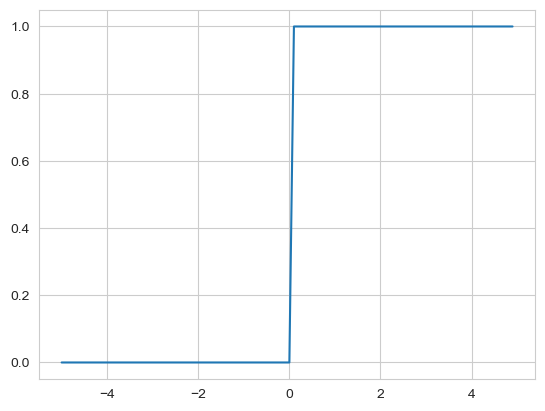

In [309]:
import matplotlib.pyplot as plt

# 계단함수처럼 나옴
plt.plot(x,y)
plt.show()

##### 시그모이드 함수

In [315]:
def sigmoid(x):
    return(1/(1+np.exp(-x)))

In [319]:
x = np.arange(-5,5,0.1)
y=sigmoid(x)
y

array([0.00669285, 0.00739154, 0.00816257, 0.0090133 , 0.0099518 ,
       0.01098694, 0.01212843, 0.01338692, 0.01477403, 0.0163025 ,
       0.01798621, 0.01984031, 0.02188127, 0.02412702, 0.02659699,
       0.02931223, 0.03229546, 0.03557119, 0.03916572, 0.04310725,
       0.04742587, 0.05215356, 0.05732418, 0.06297336, 0.06913842,
       0.07585818, 0.0831727 , 0.09112296, 0.09975049, 0.10909682,
       0.11920292, 0.13010847, 0.14185106, 0.15446527, 0.16798161,
       0.18242552, 0.19781611, 0.21416502, 0.23147522, 0.24973989,
       0.26894142, 0.2890505 , 0.31002552, 0.33181223, 0.35434369,
       0.37754067, 0.40131234, 0.42555748, 0.450166  , 0.47502081,
       0.5       , 0.52497919, 0.549834  , 0.57444252, 0.59868766,
       0.62245933, 0.64565631, 0.66818777, 0.68997448, 0.7109495 ,
       0.73105858, 0.75026011, 0.76852478, 0.78583498, 0.80218389,
       0.81757448, 0.83201839, 0.84553473, 0.85814894, 0.86989153,
       0.88079708, 0.89090318, 0.90024951, 0.90887704, 0.91682

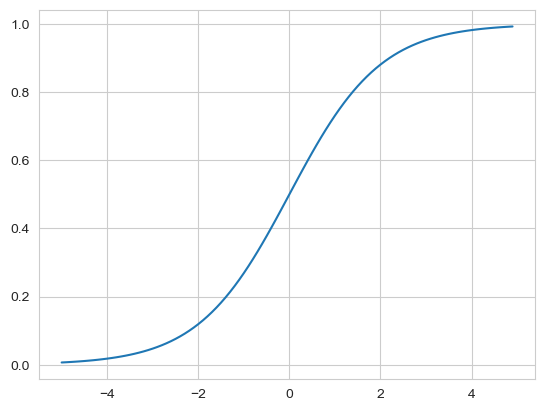

In [321]:
plt.plot(x,y)
plt.show()

In [329]:
x = np.array([1,2]) #입력층
w = np.array([[1,1,1],[2,2,2]]) # 가중치
b = np.array([1,1,1])

A1=np.dot(x,w)+b #행렬 곱 - 인공신경망 입력층 * 가중치를 계산하기위해 사용 

# 시그모이드 함수를 사용
Z1 = sigmoid(A1)
Z1 # 이런 식으로 확률로 계산할 수 있는데 합해서 모두 100 % 가 나와야함

array([0.99752738, 0.99752738, 0.99752738])

In [333]:
w2 = np.random.rand(3,2)
b2 = np.random.rand(2)

A2 = np.dot(Z1,w2)+b2
A2

array([2.63019391, 2.96559411])

In [335]:
Z2 = sigmoid(A2)
Z2

array([0.93277971, 0.95099536])

In [337]:
w3=np.random.rand(2,2)
b3 = np.random.rand(2)

A3 = np.dot(Z2,w3) + b3
A3

array([0.49290995, 1.55707647])

In [339]:
def init_network():
    net = {}
    net['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    net['B1'] = np.array([0.1, 0.2, 0.3])
    net['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    net['B2'] = np.array([0.1, 0.2])
    net['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
    net['B3'] = np.array([0.1, 0.2])
    return net

In [349]:
def forward(net, x):
    w1, w2, w3 = net['W1'], net['W2'], net['W3']
    b1, b2, b3 = net['B1'], net['B2'], net['B3']

    a1 = np.dot(x, w1) + b1
    z1 = sigmoid(a1)

    a2 = np.dot(z1, w2) + b2
    z2 = sigmoid(a2)

    a3 = np.dot(z2, w3) + b3
    
    return a3

In [355]:
net = init_network()
net

x = np.array([1,2])
y = forward(net,x)
y

array([0.32403126, 0.71230655])

##### 분류 모델 출력층 설계하기

In [363]:
a = np.array([0.3, 2.9, 4]) # 출력층에서 통과된 값

exp_a = np.exp(a) # 자연상수
exp_a

array([ 1.34985881, 18.17414537, 54.59815003])

In [365]:
sum_exp_a = np.sum(exp_a)
sum_exp_a

74.1221542101633

In [369]:
y = exp_a/sum_exp_a
y

array([0.01821127, 0.24519181, 0.73659691])

In [393]:
def softmax(x):
    c = np.max(x)
    exp_a = np.exp(x-c) # 값이 너무 커지면 계산이 안되서 이 변수를 생성한거임
    sum_exp_a = np.sum(exp_a)
    y = exp_a/sum_exp_a
    return y

In [395]:
a = np.array([0.3, 2.9, 4])
softmax(a)

array([0.01821127, 0.24519181, 0.73659691])

In [397]:
a = np.array([1010,1000,990]) # 값이 커졌다고 계산이 안됨
softmax(a)

array([9.99954600e-01, 4.53978686e-05, 2.06106005e-09])

In [411]:
x = np.array([[0.1,0.2 , 0.7],
             [0.3, 0.4, 0.3]])

# softmax(x)
# np.max(x) 최대값을 각각 구해야함
c = np.max(x,axis=1).reshape(-1,1) # 자동행 1열로 만들어줌

exp_a = np.exp(x-c)

sum_exp_a = np.sum(exp_a,axis=1).reshape(-1,1) # 각각의 행끼리 확률을 구할 수 있게

y=exp_a / sum_exp_a
y

array([[0.25462853, 0.28140804, 0.46396343],
       [0.32204346, 0.35591307, 0.32204346]])

In [413]:
x.ndim

2

In [423]:
def softmax(x):
    if x.ndim==1:
        c = np.max(x)
        exp_a = np.exp(x-c)
        sum_exp_a = np.sum(exp_a)
        y = exp_a/sum_exp_a
        return y
    elif x.ndim ==2:
        c = np.max(x,axis=1).reshape(-1,1) # 자동행 1열로 만들어줌
        exp_a = np.exp(x-c)
        sum_exp_a = np.sum(exp_a,axis=1).reshape(-1,1) # 각각의 행끼리 확률을 구할 수 있게 
        y=exp_a / sum_exp_a
        return y


In [421]:
softmax(x)

array([[0.25462853, 0.28140804, 0.46396343],
       [0.32204346, 0.35591307, 0.32204346]])

In [425]:
softmax(a)

array([9.99954600e-01, 4.53978686e-05, 2.06106005e-09])

In [460]:
def forward(net, x):
    w1, w2, w3 = net['W1'], net['W2'], net['W3']
    b1, b2, b3 = net['b1'], net['b2'], net['b3']

    a1 = np.dot(x, w1) + b1
    z1 = sigmoid(a1)

    a2 = np.dot(z1, w2) + b2
    z2 = sigmoid(a2)

    a3 = np.dot(z2, w3) + b3
    y = softmax(a3)
    return a3

In [429]:
net = init_network()
net

x = np.array([1,2])
y = forward(net,x)
y

array([0.32403126, 0.71230655])

##### 이미지 예측

In [432]:
import pickle

f = open('sample_weight.pkl','rb')

net = pickle.load(f)
f.close()

# 객체 그 자체를 저장할 수 있음
# 학습이 완료된 가중치들을 저장하는 거임


In [436]:
net
# 미리 수렴된 가중치들

{'b2': array([-0.01471108, -0.07215131, -0.00155692,  0.12199665,  0.11603302,
        -0.00754946,  0.04085451, -0.08496164,  0.02898045,  0.0199724 ,
         0.19770803,  0.04365116, -0.06518728, -0.05226324,  0.0113163 ,
         0.03049979,  0.04060355,  0.0695399 , -0.07778469,  0.0692313 ,
        -0.09365533,  0.0548001 , -0.03843745,  0.02123107,  0.03793406,
        -0.02806267, -0.01818407,  0.06870425,  0.0542943 ,  0.0674368 ,
         0.06264312, -0.0233236 , -0.01589135,  0.01860516,  0.01839287,
        -0.01568104, -0.07422207, -0.01606729, -0.02262172, -0.01007509,
         0.0434415 , -0.12020151,  0.02802471, -0.07591944, -0.00533499,
        -0.08935217, -0.0181419 ,  0.0330689 , -0.01812706, -0.07689384,
        -0.02715412, -0.03847084, -0.05315471, -0.02153288,  0.06898243,
         0.02431128, -0.00333816,  0.00817491,  0.03911701, -0.02924617,
         0.07184725, -0.00356748,  0.02246175,  0.03987982, -0.04921926,
         0.02454282,  0.05875788,  0.08505439

In [438]:
net.keys()

dict_keys(['b2', 'W1', 'b1', 'W2', 'W3', 'b3'])

In [440]:
net['W1'].shape,net['W2'].shape,net['W3'].shape
# 785개의 가중치 50개의 은닉층 , 50개의 가중치 100개의 은닉층 100개의 가중치 10개의 출력층

((784, 50), (50, 100), (100, 10))

In [442]:
net['b1'].shape,net['b2'].shape,net['b3'].shape


((50,), (100,), (10,))

In [444]:
f = open('MNIST_DATA.dat','rb')
X,Y = pickle.load(f)
f.close()

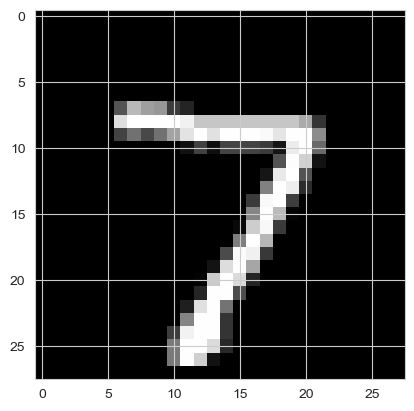

In [446]:
plt.imshow(X[0],cmap='gray')
plt.show()

In [448]:
X.shape

(10000, 28, 28)

In [458]:
X_scaled = X.reshape(10000,784) / 255 # 정규화를 시켜준건데 이미지는 어차피 255를 넘지 않기 때문에 255로 나눠주면 자동으로 minmaxscale이 되는거임
X_scaled.shape
# (10000, 28, 28) 이거를 1자로 쭉 펼친거임

X_scaled[0] # 0에 가까울 수록 검은색 흰색에 가까울수록 255에 가까움

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [470]:
count = 0

for i in range(len(X_scaled)):
    a = X_scaled[i]
    y=forward(net,a)

    pred = np.argmax(y) # 가장 큰 값을 넣어줌
    real = np.argmax(Y[i])

    # print(pred,real) #왼쪽이 예측한값 오른쪽이 실제값
    if pred == real:
        count +=1

count/len(X_scaled)

0.9352

##### 분류 모델일때 오차 구하는법

In [476]:
t = np.array([0,1,0]) # 실제값
y = np.array([0.1, 0.3, 0.6]) # 예측값

# sum(t*y)  #확인하는 방법? 그냥 곱하라고한다
-np.sum(t * np.log(y + 1e-8)) # 효율적인 확인방법이라고 한다. -> 크로스 엔트로피 손실값


1.2039727709926034

###### 몰랐던거 설명
- log 함수의 입력값이 0이 되는 것을 방지하기 위해 아주 작은 값을 더합니다.
- y.size는 3이므로, reshape(-1, 3)은 Numpy에게 "이 배열을 원소 개수가 3인 2차원 배열로 변환해라"라는 의미가 됩니다.
-1은 "알아서 맞춰줘"라는 의미로, Numpy가 자동으로 맞춰주기 때문에, 결과적으로 1개의 행을 가진 2차원 배열로 변환됩니다

##### 크로스 엔트로피 손실값 함수

In [490]:
# 크로스 엔트로피 손실값 함수
def cross_entropy_error(y,t):
    delta = 1e-9 # log 함수의 입력값이 0이 되는 것을 방지하기 위해 아주 작은 값을 더합니다.
    if y.ndim ==1:
        t = t.reshape(-1,t.size) #이게 왜 2차원으로 바뀌는지
        y = y.reshape(-1,y.size)
        
    size = len(y)
    return -np.sum(np.log(y[np.arange(size),t]+delta))

In [492]:
t = np.array([1,2])
y = np.array([[0.1,0.8,0.1], [0.6, 0.3,0.1]])

# t= np.array([1])
# y=np.array([0.1,0.8,0.1])

cross_entropy_error(y,t)

2.525728633058255

#### 미분 함수 구현하기

In [498]:
def numerical_diff(f,x):
    h =1e-4
    return (f(x+h) - f(x-h))/(2*h)

In [500]:
def func1(x):
    return x**2

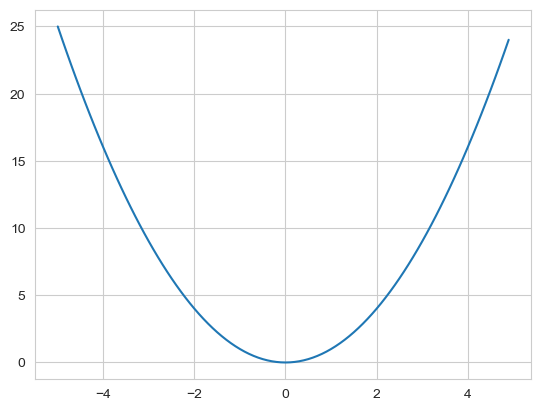

In [502]:
x = np.arange(-5,5,0.1)
y=func1(x)

plt.plot(x,y)
plt.show()

In [504]:
numerical_diff(func1,2)

4.000000000004

In [506]:
def func2(x):
    return x[0]**2 +x[1]**2

In [ ]:
# x[idx] = tmp_val + h, x[idx] = tmp_val - h: x의 각 위치에서 값에 h를 더하거나 빼서 함수의 변화를 계산합니다.
# grad[idx] = (fxh1 - fxh2) / (2 * h): numerical_diff와 같은 방식으로 각 위치에서의 기울기를 계산하고, 
# 이를 grad 배열에 저장합니다.

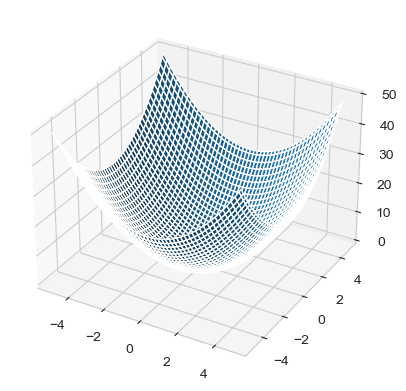

In [514]:
x = np.arange(-5,5,0.1)
y = np.arange(-5,5,0.1)

X, Y = np.meshgrid(x,y)
# X

Z = func2([X,Y])

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(X,Y,Z)

plt.show()

In [526]:
def numerical_gradient(f,x):
    h =1e-4
    grad = np.zeros_like(x)
    # print(grad)

    for idx in np.ndindex(x.shape):
        # print(idx)
        tmp_val = x[idx]

        x[idx] = tmp_val+h # 예를 들어 0,0번째에 h를 살짝 더한 값을
        fxh1 =f(x)         # 여기에 넣겠다

        x[idx] = tmp_val -h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2)/(2*h)
        x[idx] = tmp_val # 원상 복구
    return grad        

In [524]:
a = np.array([[1,2],[3,4]])
numerical_gradient(func1,a)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


In [528]:
a = np.array([1,2])
numerical_gradient(func2,a)

array([ 5000, 15000])

#### 딥러닝 모델 구현
- 딥러닝 뜯어보는 개념

In [592]:
class My_Net:

    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size
        self.params = {}
        self.params['w1'] = np.random.rand(I, H)  # 가중치를 랜덤 값으로 설정함
        self.params['b1'] = np.random.rand(H)
        self.params['w2'] = np.random.rand(H, O)
        self.params['b2'] = np.random.rand(O)

    def predict(self, x):
        w1, w2 = self.params['w1'], self.params['w2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, w1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, w2) + b2
        y = softmax(a2)
        return y

    def loss(self, x, t):  # 오차 계산
        y = self.predict(x)
        return cross_entropy_error(y, t) # 예측값 , 실제값 오차 계산해줌

    def score(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1) # 높은거 순으로 저장
        t = np.argmax(t, axis = 1)
        return np.sum(y == t) / len(x)  # 정확도

    def fit(self, x, t):
        loss = lambda i : self.loss(x, t)
        grads = {}
        grads['w1'] = numerical_gradient(loss, self.params['w1'])
        grads['b1'] = numerical_gradient(loss, self.params['b1'])
        grads['w2'] = numerical_gradient(loss, self.params['w2'])
        grads['b2'] = numerical_gradient(loss, self.params['b2'])
        return grads

In [574]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()

X = iris.data
Y = iris.target

train_x,test_x,train_y,test_y = train_test_split(X,Y)

In [603]:
len(train_x)

112

In [578]:
network = My_Net(4, 8, 3)
network.params # 학습값은아니고 랜덤 값? 이라고함

{'w1': array([[0.83129015, 0.36850924, 0.84122672, 0.53383093, 0.14628328,
         0.62341326, 0.98744704, 0.16786463],
        [0.89050515, 0.3111861 , 0.40873072, 0.54243904, 0.32684856,
         0.0306825 , 0.2582546 , 0.96112813],
        [0.65233542, 0.66448598, 0.86124749, 0.42094369, 0.14719699,
         0.58658965, 0.67094143, 0.64882205],
        [0.32604897, 0.17166007, 0.33026873, 0.60913636, 0.50420103,
         0.51218929, 0.54020896, 0.55855681]]),
 'b1': array([0.94423726, 0.21897062, 0.29947921, 0.20239197, 0.69402707,
        0.83707542, 0.02712649, 0.57227546]),
 'w2': array([[0.67018314, 0.42535789, 0.12669208],
        [0.42401151, 0.80857771, 0.52164014],
        [0.40376607, 0.71847627, 0.59729985],
        [0.16687434, 0.17031783, 0.66874875],
        [0.93231342, 0.01222091, 0.30953908],
        [0.93526454, 0.84692178, 0.53373646],
        [0.35253418, 0.43301829, 0.83861917],
        [0.35444782, 0.24846903, 0.21351268]]),
 'b2': array([0.55283857, 0.96647176

In [594]:
from tqdm import tqdm  # for문의 진행 상황을 알 수 있는 라이브러리

network = My_Net(4, 8, 3)

train_losses = []
test_losses = []

for i in tqdm(range(1000)):
    
    mask = np.random.choice(112, 80)
    
    x_batch = train_x[mask]
    t_batch = train_y[mask]

    grad = network.fit(x_batch, t_batch)

    for key in ('w1', 'b1', 'w2', 'b2'):
        network.params[key] -= grad[key] * 0.1 # 경사하강법

    loss = network.loss(train_x, train_y)
    test_loss = network.loss(test_x, test_y)

    train_losses.append(loss)
    test_losses.append(test_loss)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.48it/s]


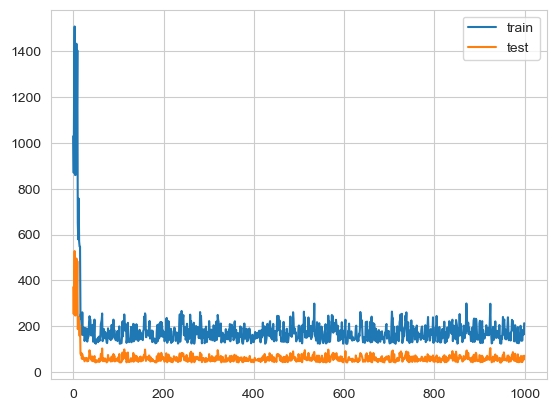

In [599]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train','test'])
plt.show()